In [1]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
res_model=IntegrableResonanceModel(3,1)

In [3]:
"""
For calls to solve_ivp variable order should be:
    y[0] = theta
    y[1] = theta*
    y[2] = J
    y[3] = J*
"""

def ydot(t,y):
    """
    dy/dt for scipy.integrate.solve_ivp
    """
    return res_model.flow_vec(y)

def ydot_jac(t,y):
    """
    grad[dy/dt] for scipy.integrate.solve_ivp
    """
    return res_model.flow_jac(y)

def event(t,y,J0):
    """
    Determine when J returns to initial
    value, J0
    """
    J = y[2]
    return J - J0



In [4]:
def calc_frequencies(delta_theta,Jstar):
    """
    Determine the dynamical frequencies associated with 
    initial libration amplitude delta_thetaand conserved 
    quantity Jstar.
    
    Based on Henrard (1990, doi: 10.1007/BF00048581).
    
    The equations of motion are integrated until the trajectory
    returns to it's initial value of J  (with the additional
    condtion that dJ/dt has the same sign as it does initially).
    The time it takes for J to return to its initial value is
    the simply libration period. 
    
    The secular frequency is determined as follows:
    the angle $\theta^*$ is related to the canonical 
    action-angle variables $({\cal J},\zeta,I^*,\phi^*)$ by: 
    
    $$
        \theta^* = \phi^* + \rho(\zeta; I^*,{\cal J})
    $$
    
    where $\rho$ is a 2pi periodic function of $\zeta$.
    Therefore, after one libration period,
    $$
     \theta^* = \phi^*(0) + \frac{\Omega_{sec}}\times T
    $$
    where T is the libration period. The secular frequency
    can then be determined from the change in \theta^* over
    one libration period.
    
    Arguments
    ---------
    delta_theta : float
        Intial libration amplitude.
        
    Returns
    -------
    Omega_res : float
        Frequency of (J,theta) degree of freedom.
        
    Omega_sec : float
        Frequency of (J*,theta*) degree of freedom.
        This is the mean precession rate of theta*.
        Note that this Omega_sec differs from the one
        defined in the paper by eps*b_s
        
    Notes
    -----
    Trajectories are initialized with
        y0 = [np.pi + delta_theta,0,J_eq,Jstar]
    Strictly speaking, 
       $$ J  \ne J_eq $$ 
    when $\theta$ is at it's maximum libration value
    so the *true* libration amplitude may differ 
    slightly from the user-specified value 'delta_theta'.
    However, this difference is generally negligible.
    """
    # Symmetric in libration amplitude
    delta_theta = np.abs(delta_theta)
    assert delta_theta <= np.pi, "Not a valid libration amplitude!"
    
    # Set ICs 
    y0 = res_model.elliptic_fixed_point(Jstar)
    y0[0] += delta_theta
    J0 = y0[2]
    
    # At fixed point, get freq. of linearized system
    if np.isclose(delta_theta,0):
        fvec = res_model.flow_vec(y0)
        jac = res_model.flow_jac(y0)
        Omega_res = np.max(np.imag(np.linalg.eigvals(jac)))
        Omega_sec = fvec[1]
        
    # For libration ampltiude of pi, take 
    # secular frequency at usntable fixed point
    # and set Omega_res = 0
    elif np.isclose(delta_theta,np.pi):
        Omega_res = 0
        yunst = res_model.unstable_fixed_point(Jstar)
        Omega_sec = res_model.flow_vec(yunst)[1]
        
    # ... otherwise do integration
    else:
        # Stop when J returns to J0 with the proper dJ/dt direction
        eventfn = lambda t,y: event(t,y,J0-1e-14)
        eventfn.terminal=True
        eventfn.direction = +1
        sol = solve_ivp(ydot,
                        t_span=(0,np.inf),
                        y0=y0,
                        jac=ydot_jac,
                        method='Radau',
                        events=[eventfn]                       
                       )

        # Resonant libration period/freq. 
        T = sol.t_events[0][0]
        Omega_res = 2 * np.pi / T 

        # Get state at t=T. 
        # Annoyingly, this is not actually
        # returned by the previous call to solve_ivp.
        sol2 = solve_ivp(ydot,
                        t_span=(sol.t[-1],T),
                        y0=sol.y[:,-1],
                        jac=ydot_jac,
                        method='Radau'
                        )
        theta_star_final = sol2.y[1][-1]
        Omega_sec = theta_star_final / T

    return Omega_res,Omega_sec

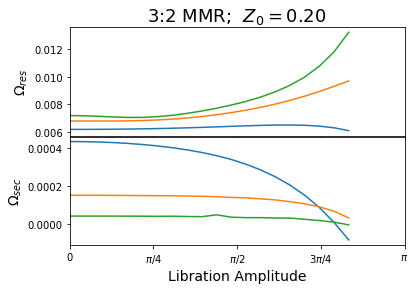

In [12]:
fig,ax = plt.subplots(2,sharex=True,figsize=(6,4))
plt.subplots_adjust(hspace=0.01)

amps = np.linspace(0,5*np.pi/6,20)
for Z0 in [0.05,0.1,0.2]:
    Jstar = res_model.Zsq_to_J * (Z0)**2
    Omega_res,Omega_sec = np.zeros((2,len(amps))) 
    for i,amp in enumerate(amps):
        Omega_res[i],Omega_sec[i]= calc_frequencies(amp,Jstar)
    ax[0].plot(amps,Omega_res)
    ax[1].plot(amps,Omega_sec)
# NOTE: Omega_sec needs to be corrected with
# addition of $\epsilon * b_s$ 
ax[1].set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
ax[1].xaxis.set_ticklabels(["0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]);
ax[0].set_title("{}:{} MMR;  $Z_0={:.2f}$".format(res_model.j,res_model.j-res_model.k,Z0),fontsize = 18)
ax[1].set_xlim(0,np.pi)
ax[1].set_xlabel("Libration Amplitude",fontsize=14)
ax[0].set_ylabel(r"$\Omega_{res}$",fontsize=14)
ax[1].set_ylabel(r"$\Omega_{sec}$",fontsize=14)